In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [2]:
"""
Implement vectorized metrics

x, y -- np.array
"""

def euclid_m(x, y):
    return np.sum((x - y)**2, axis=1) ** 0.5

def euclid2_m(x, y):
    return np.sum((x - y)**2, axis=1)

def manhattan_m(x, y):
    return np.sum(abs(x - y), axis=1)

def chebyshev_m(x, y):
    return np.max(abs(x - y), axis=1)

def sedate_m(x, y, r=0.5, p=2):
    return np.sum((x - y)**p, axis=1) ** r

In [3]:
class KMeans1:
    """
    X -- np.array
        Matrix of input features
    k -- int
        Number of clusters
    m -- func
        Returns distance value between 2 given points
    """
    
    def __init__(self, X, k, metric):
        self.X = X
        self.k = k
        self.m = metric
        
    def initialize_centroids(self):
        """ 
        Returns:
        
        Array of shape (k, n_features), 
            containing k centroids from the initial points
        """

        temp = self.X.copy()
        np.random.shuffle(temp)
        return temp[:self.k, :]
             
    def closest_centroid(self, centroids):
        """
        Returns:
        
        Array of shape (n_examples, ), 
            containing index of the nearest centroid for each point based on given metric
        """
        
        n_samples = self.X.shape[0]
        idx = []
        
        for i in range(n_samples):
            dist = self.m(self.X[i, :], centroids)
            idx.append(np.argmin(dist))
        
        return np.asarray(idx)
    
    def move_centroids(self, centroids):
        """
        Returns:
        
        Array of shape (n_clusters, n_features),
        containing the new centroids assigned from the points closest to them
        """
        
        idx = self.closest_centroid(centroids)
        res = []
        
        for i in range(self.k):
            filt = (idx == i)
            res.append(self.X[filt, :].mean(axis=0))
        
        return np.asarray(res)

    def final_centroids(self):
        """
        Returns:
        
        clusters -- list of arrays, containing points of each cluster
        centroids -- array of shape (n_clusters, n_features),
            containing final centroids 
        """
        
        clusters = []
        prev_centroids = self.initialize_centroids()
        new_centroids = self.move_centroids(prev_centroids)
        
        while max(self.m(prev_centroids, new_centroids)) != 0.:
            prev_centroids = new_centroids.copy()
            new_centroids = self.move_centroids(new_centroids)
        
        idx = self.closest_centroid(new_centroids)
        
        for i in range(self.k):
            filt = (idx == i)
            clusters.append(self.X[filt, :])

        return clusters, new_centroids

In [4]:
#generate data to test K-Means
np.random.seed(17)
X = np.vstack([np.random.randn(150, 2) + np.array([-2, 1]),
              np.random.randn(150, 2) + np.array([2.5, 1.5]),
              np.random.randn(150, 2) + np.array([-0.5, -1]),
              np.random.randn(150, 2) + np.array([-5.5, -3])])
print('X.shape: ', X.shape)

X.shape:  (600, 2)


Text(0, 0.5, 'Feature2')

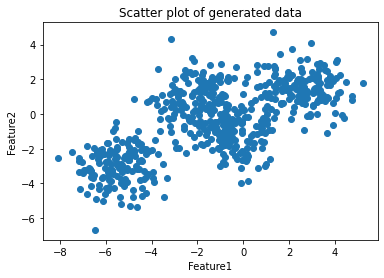

In [5]:
#visualize the data
plt.scatter(X[:, 0], X[:, 1])
plt.title('Scatter plot of generated data')
plt.xlabel('Feature1')
plt.ylabel('Feature2')

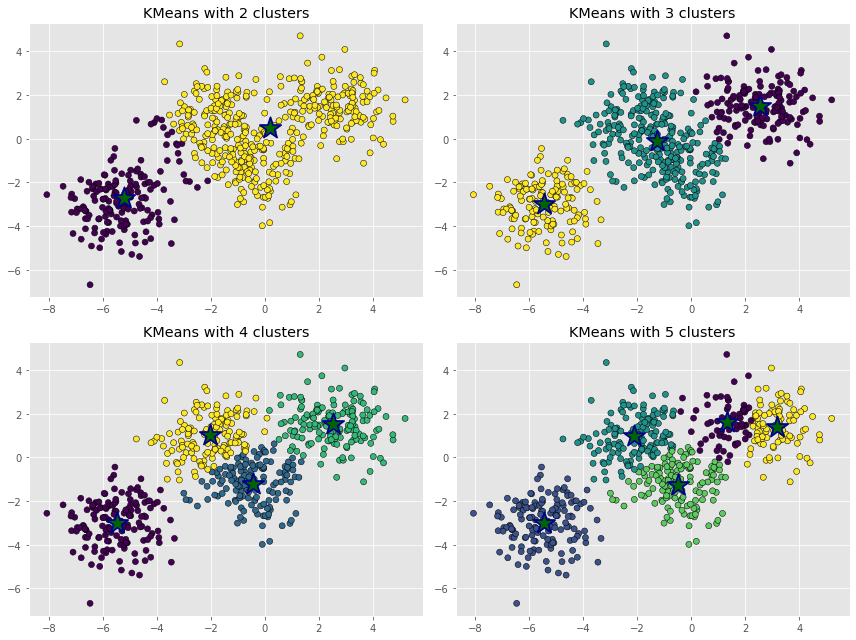

In [6]:
#perform K-Means clustering with k=[2,3,4,5] and metric=euclid2_m
plt.figure(figsize=(12, 9))
plt.style.use('ggplot')
for i in range(2, 6):
    km = KMeans1(X, k=i, metric=euclid2_m)
    _, centroids = km.final_centroids()
    closest = km.closest_centroid(centroids)
    
    plt.subplot(2, 2, i-1)
    plt.scatter(X[:, 0], X[:, 1], c=closest, edgecolors='black')
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=500, c='darkgreen', 
                edgecolors='darkblue', linewidths=1.75)
    plt.title(f'KMeans with {i} clusters')

plt.tight_layout()

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

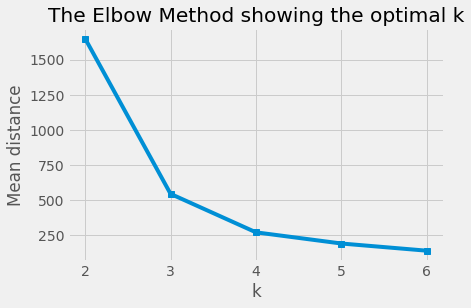

In [7]:
#let's figure out the best k value using elbow method and metric=euclid2_m
def mean_distance(X, k, metric=euclid2_m):
    '''
    Returns:
    
    Array, containing mean of sum distances 
        from centroid to each point in the cluster for k clusters
    '''
    w = []
    for i in range(2, k+1):
        km = KMeans1(X, i, metric=metric)
        clusters, centroids = km.final_centroids()
        temp = 0.
        for j in range(i):
            temp += np.sum((clusters[j] - centroids[j])**2)
        w.append(temp / i)
    
    return np.asarray(w)

k_clusters = range(2,7)
distances = mean_distance(X, 6)
plt.style.use('fivethirtyeight')
plt.plot(k_clusters, distances, marker='s')
plt.xlabel('k')
plt.ylabel('Mean distance')
plt.title('The Elbow Method showing the optimal k')

In [8]:
#seems like k=3 is a pretty reasonable choice. Let's compare silhouette_score`s for k=3 and k=4 with metric=euclid2_m
kmeans3 = KMeans1(X, k=3, metric=euclid2_m)
kmeans4 = KMeans1(X, k=4, metric=euclid2_m)

_, centroids3 = kmeans3.final_centroids()
_, centroids4 = kmeans4.final_centroids()

closest3 = kmeans3.closest_centroid(centroids3)
closest4 = kmeans4.closest_centroid(centroids4)

print(f'Silhouette score:\n\
    k=3: {silhouette_score(X, closest3)}\n\
    k=4: {silhouette_score(X, closest4)}')

Silhouette score:
    k=3: 0.5285911456969501
    k=4: 0.523042958188585


In [9]:
#compare mean of sum distances for k=3 with the results from sklearn's KMeans
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, random_state=17)
km.fit(X)
print(f'Mean of sum distances with k=3:\n\
    KMeans1: {distances[1]}\n\
    SKLearn`s KMeans: {km.inertia_ / 3}')

Mean of sum distances with k=3:
    KMeans1: 545.193117023216
    SKLearn`s KMeans: 545.1931170232161
